In [302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [303]:
data = pd.read_csv('/content/house_prices.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [304]:
data.drop(columns='Id', inplace=True)

In [305]:
target = 'SalePrice'
num_cols = set(data.drop(columns=target).select_dtypes(['int', 'float']).columns)
str_cols = set(data.drop(columns=target).select_dtypes(['object']).columns)
cat_cols = []

### Обработка численных колонок

Некоторые из колонок предстваляют собой категориальные фичи, их надо выделить

In [306]:
data[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OpenPorchSF    1460 non-null   int64  
 1   ScreenPorch    1460 non-null   int64  
 2   BedroomAbvGr   1460 non-null   int64  
 3   YearBuilt      1460 non-null   int64  
 4   MasVnrArea     1452 non-null   float64
 5   LotArea        1460 non-null   int64  
 6   KitchenAbvGr   1460 non-null   int64  
 7   WoodDeckSF     1460 non-null   int64  
 8   BsmtUnfSF      1460 non-null   int64  
 9   MoSold         1460 non-null   int64  
 10  GrLivArea      1460 non-null   int64  
 11  LotFrontage    1201 non-null   float64
 12  GarageCars     1460 non-null   int64  
 13  YrSold         1460 non-null   int64  
 14  1stFlrSF       1460 non-null   int64  
 15  BsmtFinSF1     1460 non-null   int64  
 16  3SsnPorch      1460 non-null   int64  
 17  OverallQual    1460 non-null   int64  
 18  Fireplac

In [307]:
com_index_MSSubClass = data['MSSubClass'].value_counts()[data['MSSubClass'].value_counts() < 100].index
data.loc[data[data['MSSubClass'].isin(com_index_MSSubClass)].index, 'MSSubClass'] = 'less100'
cat_cols.append('MSSubClass')

In [308]:
data['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

Восстановить колонку KotFrontage помогут нам MSZoning, Street, Neighborhood

In [309]:
# Более тонкое заполнение с группировкой по нескольким категориям
help_cols = ['Street', 'MSZoning', 'Neighborhood']

for  key, value in data[[*help_cols, 'LotFrontage']].groupby(help_cols).indices.items():
    data['LotFrontage'].loc[value] = data['LotFrontage'].loc[value].fillna(data['LotFrontage'].loc[value].median())

data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace=True) #(1 остался)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


MasVnrArea, MasVnrType (значения пропущены в одних и тех же строках, заменим на самое популярное)

In [310]:
data.MasVnrArea.fillna(0, inplace=True)
data.MasVnrType.fillna('None', inplace=True)

In [311]:
data.GarageYrBlt.fillna(0, inplace=True)
# Чем больше год гаража, тем дороже здание (гараж новее), поэтому его отсутствие заменим нулём

In [312]:
num_cols.discard('MSSubClass')

### Baseline

In [313]:
X, y = data[num_cols], data[target]

X_scaled = StandardScaler().fit_transform(X)

reg = LinearRegression().fit(X_scaled, y)
print('scaled:')
print(mean_absolute_error(reg.predict(X_scaled), y))
print(reg.score(X_scaled, y))
print()

reg = LinearRegression().fit(X, y)
print('initial:')
print(mean_absolute_error(reg.predict(X), y))
print(reg.score(X, y))

scaled:
21176.230570476324
0.8109823428345941

initial:
21175.63190966774
0.8109826513200301


### Уменьшение размерности

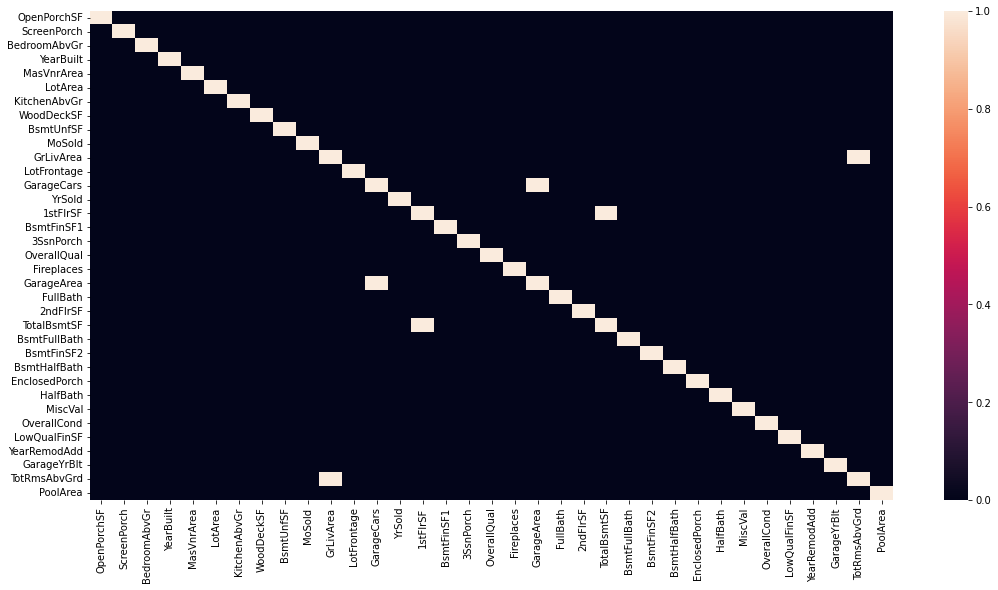

In [314]:
plt.figure(figsize=(18, 9))
sns.heatmap(abs(data[num_cols].corr()) > 0.8)

In [315]:
len(num_cols)

35

In [316]:
num_cols.discard('TotRmsAbvGrd')
num_cols.discard('GarageCars')
num_cols.discard('1stFlrSF')
num_cols.discard('GarageYrBlt')

In [317]:
X, y = data[num_cols], data[target]

X_scaled = StandardScaler().fit_transform(X)

reg = LinearRegression().fit(X_scaled, y)
print('scaled:')
print(mean_absolute_error(reg.predict(X_scaled), y))
print(reg.score(X_scaled, y))
print()

reg = LinearRegression().fit(X, y)
print('initial:')
print(mean_absolute_error(reg.predict(X), y))
print(reg.score(X, y))

scaled:
21065.04428985251
0.8020820490166378

initial:
21062.994366241335
0.8020919993000036


mae слегка упала, однако кожффициент детерминации тоже

In [318]:
for model in RidgeCV(), LassoCV():
    X, y = data[num_cols], data[target]

    X_scaled = StandardScaler().fit_transform(X)

    print(model)

    reg = model.fit(X_scaled, y)
    print('scaled:')
    print(mean_absolute_error(reg.predict(X_scaled), y))
    print(reg.score(X_scaled, y))
    print()

    reg = model.fit(X, y)
    print('initial:')
    print(mean_absolute_error(reg.predict(X), y))
    print(reg.score(X, y))

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
scaled:
21052.84252021913
0.8020288830005258

initial:
21052.963376607786
0.8020419365068411
LassoCV()
scaled:
21110.87421485677
0.8004346383612317

initial:
24792.961354800074
0.7235726141015746


In [319]:
data[str_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   GarageFinish   1379 non-null   object
 1   SaleCondition  1460 non-null   object
 2   Neighborhood   1460 non-null   object
 3   BsmtExposure   1422 non-null   object
 4   Utilities      1460 non-null   object
 5   RoofStyle      1460 non-null   object
 6   ExterQual      1460 non-null   object
 7   Exterior2nd    1460 non-null   object
 8   GarageCond     1379 non-null   object
 9   PoolQC         7 non-null      object
 10  Heating        1460 non-null   object
 11  MiscFeature    54 non-null     object
 12  BsmtQual       1423 non-null   object
 13  Exterior1st    1460 non-null   object
 14  Foundation     1460 non-null   object
 15  MSZoning       1460 non-null   object
 16  Condition2     1460 non-null   object
 17  MasVnrType     1460 non-null   object
 18  Functional     1460 non-null

Везде кроме Electrical Null значения осмысленные, их заполнять не нужно

In [320]:
data.GarageFinish.fillna(data.GarageFinish.mode().values[0], inplace=True)

In [321]:
str_cols.update(['MSSubClass'])
cat_cols = str_cols

In [322]:
data[cat_cols | num_cols]

,GarageFinish,SaleCondition,Neighborhood,OpenPorchSF,BsmtExposure,ScreenPorch,BedroomAbvGr,YearBuilt,MasVnrArea,LotArea,KitchenAbvGr,Utilities,WoodDeckSF,BsmtUnfSF,RoofStyle,ExterQual,Exterior2nd,GarageCond,PoolQC,Heating,MoSold,MiscFeature,GrLivArea,LotFrontage,BsmtQual,YrSold,Exterior1st,Foundation,BsmtFinSF1,MSZoning,3SsnPorch,OverallQual,Condition2,Fireplaces,GarageArea,MasVnrType,Functional,FullBath,RoofMatl,2ndFlrSF,TotalBsmtSF,SaleType,BsmtFullBath,BsmtFinSF2,BsmtFinType1,GarageType,LandSlope,HouseStyle,BldgType,BsmtHalfBath,LotShape,BsmtCond,CentralAir,EnclosedPorch,GarageQual,HalfBath,KitchenQual,PoolArea,LotConfig,MiscVal,PavedDrive,BsmtFinType2,ExterCond,Condition1,Fence,MSSubClass,Street,OverallCond,FireplaceQu,Electrical,LowQualFinSF,YearRemodAdd,HeatingQC,Alley,LandContour
0,RFn,Normal,CollgCr,61,No,0,3,2003,196.0,8450,1,AllPub,0,150,Gable,Gd,VinylSd,TA,NaN,GasA,2,NaN,1710,65.0,Gd,2008,VinylSd,PConc,706,RL,0,7,Norm,0,548,BrkFace,Typ,2,CompShg,854,856,WD,1,0,GLQ,Attchd,Gtl,2Story,1Fam,0,Reg,TA,Y,0,TA,1,Gd,0,Inside,0,Y,Unf,TA,Norm,NaN,60,Pave,5,NaN,SBrkr,0,2003,Ex,NaN,Lvl
1,RFn,Normal,Veenker,0,Gd,0,3,1976,0.0,9600,1,AllPub,298,284,Gable,TA,MetalSd,TA,NaN,GasA,5,NaN,1262,80.0,Gd,2007,MetalSd,CBlock,978,RL,0,6,Norm,1,460,None,Typ,2,CompShg,0,1262,WD,0,0,ALQ,Attchd,Gtl,1Story,1Fam,1,Reg,TA,Y,0,TA,0,TA,0,FR2,0,Y,Unf,TA,Feedr,NaN,20,Pave,8,TA,SBrkr,0,1976,Ex,NaN,Lvl
2,RFn,Normal,CollgCr,42,Mn,0,3,2001,162.0,11250,1,AllPub,0,434,Gable,Gd,VinylSd,TA,NaN,GasA,9,NaN,1786,68.0,Gd,2008,VinylSd,PConc,486,RL,0,7,Norm,1,608,BrkFace,Typ,2,CompShg,866,920,WD,1,0,GLQ,Attchd,Gtl,2Story,1Fam,0,IR1,TA,Y,0,TA,1,Gd,0,Inside,0,Y,Unf,TA,Norm,NaN,60,Pave,5,TA,SBrkr,0,2002,Ex,NaN,Lvl
3,Unf,Abnorml,Crawfor,35,No,0,3,1915,0.0,9550,1,AllPub,0,540,Gable,TA,Wd Shng,TA,NaN,GasA,2,NaN,1717,60.0,TA,2006,Wd Sdng,BrkTil,216,RL,0,7,Norm,1,642,None,Typ,1,CompShg,756,756,WD,1,0,ALQ,Detchd,Gtl,2Story,1Fam,0,IR1,Gd,Y,272,TA,0,Gd,0,Corner,0,Y,Unf,TA,Norm,NaN,less100,Pave,5,Gd,SBrkr,0,1970,Gd,NaN,Lvl
4,RFn,Normal,NoRidge,84,Av,0,4,2000,350.0,14260,1,AllPub,192,490,Gable,Gd,VinylSd,TA,NaN,GasA,12,NaN,2198,84.0,Gd,2008,VinylSd,PConc,655,RL,0,8,Norm,1,836,BrkFace,Typ,2,CompShg,1053,1145,WD,1,0,GLQ,Attchd,Gtl,2Story,1Fam,0,IR1,TA,Y,0,TA,1,Gd,0,FR2,0,Y,Unf,TA,Norm,NaN,60,Pave,5,TA,SBrkr,0,2000,Ex,NaN,Lvl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RFn,Normal,Gilbert,40,No,0,3,1999,0.0,7917,1,AllPub,0,953,Gable,TA,VinylSd,TA,NaN,GasA,8,NaN,1647,62.0,Gd,2007,VinylSd,PConc,0,RL,0,6,Norm,1,460,None,Typ,2,CompShg,694,953,WD,0,0,Unf,Attchd,Gtl,2Story,1Fam,0,Reg,TA,Y,0,TA,1,TA,0,Inside,0,Y,Unf,TA,Norm,NaN,60,Pave,5,TA,SBrkr,0,2000,Ex,NaN,Lvl
1456,Unf,Normal,NWAmes,0,No,0,3,1978,119.0,13175,1,AllPub,349,589,Gable,TA,Plywood,TA,NaN,GasA,2,NaN,2073,85.0,Gd,2010,Plywood,CBlock,790,RL,0,6,Norm,2,500,Stone,Min1,2,CompShg,0,1542,WD,1,163,ALQ,Attchd,Gtl,1Story,1Fam,0,Reg,TA,Y,0,TA,0,TA,0,Inside,0,Y,Rec,TA,Norm,MnPrv,20,Pave,6,TA,SBrkr,0,1988,TA,NaN,Lvl
1457,RFn,Normal,Crawfor,60,No,0,4,1941,0.0,9042,1,AllPub,0,877,Gable,Ex,CmentBd,TA,NaN,GasA,5,Shed,2340,66.0,TA,2010,CemntBd,Stone,275,RL,0,7,Norm,2,252,None,Typ,2,CompShg,1152,1152,WD,0,0,GLQ,Attchd,Gtl,2Story,1Fam,0,Reg,Gd,Y,0,TA,0,Gd,0,Inside,2500,Y,Unf,Gd,Norm,GdPrv,less100,Pave,9,Gd,SBrkr,0,2006,Ex,NaN,Lvl
1458,Unf,Normal,NAmes,0,Mn,0,2,1950,0.0,9717,1,AllPub,366,0,Hip,TA,MetalSd,TA,NaN,GasA,4,NaN,1078,68.0,TA,2010,MetalSd,CBlock,49,RL,0,5,Norm,0,240,None,Typ,1,CompShg,0,1078,WD,1,1029,GLQ,Attchd,Gtl,1Story,1Fam,0,Reg,TA,Y,112,TA,0,Gd,0,Inside,0,Y,Rec,TA,Norm,NaN,20,Pave,6,NaN,FuseA,0,1996,Gd,NaN,Lvl


In [323]:
new_data = pd.get_dummies(data[cat_cols | num_cols], drop_first=True, dummy_na=True, prefix=cat_cols)

In [324]:

X, y = new_data, data[target]

X_scaled = StandardScaler().fit_transform(X)


reg = RidgeCV(alphas=[1e-6]).fit(X_scaled, y)
print('scaled:')
print(mean_absolute_error(reg.predict(X_scaled), y))
print(reg.score(X_scaled, y))
print()


scaled:
13280.907364903727
0.9328711176806987



С категориальными признаками результаты заметно улучшились

In [325]:
(new_data.corr() > 0.8).sum()[(new_data.corr() > 0.8).sum().isin([3, 4, 5, 6])]

BsmtExposure_nan    5
GarageCond_nan      3
BsmtQual_nan        6
Foundation_Slab     4
BsmtFinType1_nan    6
GarageType_nan      3
BsmtCond_nan        6
GarageQual_nan      3
BsmtFinType2_nan    5
dtype: int64

Видим сильно коррелирующие колонки, обучим модель без них

In [326]:
corr_cols = (new_data.corr() > 0.8).sum()[(new_data.corr() > 0.8).sum().isin([3, 4, 5, 6])].index

In [327]:
X, y = new_data.drop(columns=corr_cols), data[target]

X_scaled = StandardScaler().fit_transform(X)


reg = RidgeCV(alphas=[1e-6]).fit(X_scaled, y)
print('scaled:')
print(mean_absolute_error(reg.predict(X_scaled), y))
print(reg.score(X_scaled, y))
print()


scaled:
13343.610521365268
0.9326498327490561



Паказатели незначительно ухудшились, вернёмся к предыдущим значениям

### Итоговый R^2 = 0.93, MAE = 13280
